<a href="https://colab.research.google.com/github/Adi26Datta/Stock-Sentiment-Analysis/blob/main/Notebook2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import yfinance as yf
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string
import spacy
import numpy as np
#nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.decomposition import LatentDirichletAllocation


In [ ]:
merged_df=pd.read_csv("/kaggle/input/stocks/merged.csv")
merged_df

,Unnamed: 0,Date,Close,sentiment_scores,Subjectivity,Polarity,neg,pos,neu,label,...,embedding_290,embedding_291,embedding_292,embedding_293,embedding_294,embedding_295,embedding_296,embedding_297,embedding_298,embedding_299
0,0,2010-07-21,1.348000,0.7650,0.000000,0.000000,0.000,0.292,0.708,0,...,-0.158826,0.229542,0.269480,0.005842,-0.046021,0.262490,-0.183144,-0.153383,-0.046463,0.284340
1,1,2010-07-22,1.400000,0.7882,0.000000,0.000000,0.000,0.225,0.775,1,...,-0.156490,0.210042,0.253818,0.009496,-0.055705,0.240137,-0.164799,-0.139611,-0.049336,0.274392
2,2,2010-07-23,1.419333,-0.4939,0.000000,0.000000,0.104,0.000,0.896,1,...,0.062881,0.269830,0.214982,0.006008,0.210868,0.301262,-0.174867,-0.139968,0.060738,0.081361
3,3,2010-07-26,1.396667,0.4215,0.325000,0.275000,0.107,0.142,0.751,0,...,-0.007634,0.212661,0.187982,0.004289,0.106633,0.238466,-0.152060,-0.122055,0.023708,0.122588
4,4,2010-07-27,1.370000,0.0000,0.283333,0.266667,0.000,0.000,1.000,0,...,-0.031258,0.177633,0.170767,0.002800,0.062727,0.199637,-0.131026,-0.105074,0.006160,0.128132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2600,2600,2024-12-17,479.859985,-0.0772,0.201136,0.084091,0.066,0.081,0.853,1,...,0.013713,0.199486,0.170003,0.003270,0.121335,0.220449,-0.136296,-0.110493,0.031577,0.094932
2601,2601,2024-12-18,440.130005,-0.7579,0.000000,0.000000,0.289,0.000,0.711,0,...,0.051852,0.251260,0.198919,0.002590,0.188911,0.276407,-0.167186,-0.135106,0.056094,0.083584
2602,2602,2024-12-19,436.170013,0.0000,0.000000,0.000000,0.000,0.000,1.000,0,...,-0.001963,0.216463,0.190430,0.004641,0.114818,0.241811,-0.150233,-0.122603,0.027486,0.119386
2603,2603,2024-12-20,421.059998,0.4927,0.350000,0.350000,0.000,0.208,0.792,0,...,-0.052342,0.198929,0.197446,0.008153,0.051292,0.222081,-0.143618,-0.119524,-0.001072,0.163208


In [ ]:
merged_df = merged_df.drop(columns=['Unnamed: 0'])

In [ ]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
X=merged_df.drop(columns=['label'])
y=merged_df['label']

split=int(0.7*X.shape[0])

X_train = X[:split].copy()
X_test = X[split:].copy()
y_train = y[:split]
y_test = y[split:]

In [ ]:
date=X_test['Date']
adjclose=X_test['Close']
X_train.drop(columns=['Date','Close'],inplace=True)
X_test.drop(columns=['Date','Close'],inplace=True)

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,f1_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB #(commented out, because Word2Vec uses negative values — not suitable)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
)
svc = SVC(kernel='sigmoid', gamma=1.0)  # Support Vector Classifier with sigmoid kernel
knc = KNeighborsClassifier()            # KNN
#mnb = MultinomialNB()                   non-count data
dtc = DecisionTreeClassifier(max_depth=3)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)

clfs = {
    'SVC' : svc,
    'KN' : knc,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'AdaBoost': abc,
    'BgC': bc,
    'ETC': etc,
    'GBDT':gbdt,
}


In [ ]:
def train_classifier(clf, X_train, y_train, X_test, y_test):
    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Calculate evaluation metrics
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Return a dictionary of results including the confusion matrix
    return {
        'Classifier': clf.__class__.__name__,
        'Recall': recall,
        'Precision': precision,
        'F1-score': f1score,
        'Accuracy': accuracy,
        'Confusion Matrix': conf_matrix
    }


# List to store results
results = []

# Iterate through classifiers, train, evaluate, and store results
for name, clf in clfs.items():
    # Train and evaluate the classifier
    result = train_classifier(clf, X_train, y_train, X_test, y_test)
    results.append(result)

    # Print the results for the current classifier
    print(f"For {name}")
    print(f"Recall: {result['Recall']}")
    print(f"Precision: {result['Precision']}")
    print(f"F1-score: {result['F1-score']}")
    print(f"Accuracy: {result['Accuracy']}")
    print("Confusion Matrix:")
    print(result['Confusion Matrix'])
    print("************************")

# Create a DataFrame from the results list
df = pd.DataFrame(results)

# Display the DataFrame
print(df)


For SVC
Recall: 1.0
Precision: 0.5268542199488491
F1-score: 0.6901172529313232
Accuracy: 0.5268542199488491
Confusion Matrix:
[[  0 370]
 [  0 412]]
************************
For KN
Recall: 0.5412621359223301
Precision: 0.530952380952381
F1-score: 0.5360576923076923
Accuracy: 0.5063938618925832
Confusion Matrix:
[[173 197]
 [189 223]]
************************
For DT
Recall: 0.8956310679611651
Precision: 0.5263908701854494
F1-score: 0.6630727762803235
Accuracy: 0.520460358056266
Confusion Matrix:
[[ 38 332]
 [ 43 369]]
************************
For LR
Recall: 0.8349514563106796
Precision: 0.5300462249614792
F1-score: 0.648444863336475
Accuracy: 0.5230179028132992
Confusion Matrix:
[[ 65 305]
 [ 68 344]]
************************
For RF
Recall: 0.5169902912621359
Precision: 0.5246305418719212
F1-score: 0.5207823960880196
Accuracy: 0.49872122762148335
Confusion Matrix:
[[177 193]
 [199 213]]
************************
For AdaBoost
Recall: 0.5485436893203883
Precision: 0.5330188679245284
F1-sco

In [ ]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

In [ ]:
# RandomForest
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier()

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)
random_search.fit(X_train, y_train)

# Get the best parameters and best cross-validation score
best_params = random_search.best_params_
best_cv_score = random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_cv_score}")

best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Calculate evaluation metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1score))
print(conf_matrix)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   8.2s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   8.6s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   8.4s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   9.2s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   8.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  20.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; to

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf']
}

# Initialize the SVC
svc = SVC()

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_cv_score}")

# Apply the best estimator to the test data
best_svc1 = grid_search.best_estimator_
y_pred = best_svc1.predict(X_test)

# Calculate evaluation metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1score))
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.6s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.7s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.7s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.7s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.9s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.5s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.6s
[CV] END .........................C=0.1, gamma=

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['sigmoid']
}

# Initialize the SVC
svc = SVC()

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_cv_score}")

# Apply the best estimator to the test data
best_svc1 = grid_search.best_estimator_
y_pred = best_svc1.predict(X_test)

# Calculate evaluation metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1score))
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.8s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.8s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.8s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.8s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.8s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=   0.8s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=   0.9s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=   0.9s
[CV] END ..................C=0.1, gamma=0.01, kernel=sigmoid; total time=   0.7s
[CV] END ..................C=0.1, gamma=0.01, kernel=sigmoid; total time=   0.7s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=   0.8s
[CV] END ...................C=0.1, gamma=0.1, k

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['poly']
}

# Initialize the SVC
svc = SVC()

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_cv_score}")

# Apply the best estimator to the test data
best_svc1 = grid_search.best_estimator_
y_pred = best_svc1.predict(X_test)

# Calculate evaluation metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1score))
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.7s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.8s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.7s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.6s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.7s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.7s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.6s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.7s
[CV] END .....................C=0.1, gamma=0.01

In [ ]:
param_grid = [
    {'C': [0.1], 'gamma': [1], 'kernel': ['sigmoid']},
    {'C': [0.1], 'gamma': [1], 'kernel': ['poly']},
    {'C': [10], 'gamma': [1], 'kernel': ['linear']}
]

# Initialize the SVC
svc = SVC()

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_cv_score}")

# Apply the best estimator to the test data
best_svc1 = grid_search.best_estimator_
y_pred = best_svc1.predict(X_test)

# Calculate evaluation metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1score))
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
Best Cross-Validation Score: 0.5227773596266747
Accuracy: 0.53
Precision: 0.54
Recall: 0.80
F1-score: 0.64
[[ 89 281]
 [ 83 329]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.24      0.33       370
           1       0.54      0.80      0.64       412

    accuracy                           0.53       782
   macro avg       0.53      0.52      0.49       782
weighted avg       0.53      0.53      0.49       782

[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.8s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.8s
[CV] END .......................C=10, gamma=1, kernel=linear; total time=   0.7s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0

In [ ]:
# Initialize the AdaBoostClassifier
ada = AdaBoostClassifier()

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1, 1, 10],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=ada,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best cross-validation score
best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_cv_score}")

# Apply the best estimator to the test data
best_ada = grid_search.best_estimator_
y_pred = best_ada.predict(X_test)

    # Calculate evaluation metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

    # Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1score))
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=50; total time=   5.4s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=50; total time=   5.4s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=50; total time=   5.4s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=50; total time=   5.4s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=50; total time=   5.3s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=100; total time=  10.5s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=100; total time=  10.5s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=100; total time=  10.7s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=100; total time=  10.9s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=100; total time=  11.0s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=200; total time=  22.5s
[CV] END algorithm=

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Initialize the AdaBoostClassifier
ada = AdaBoostClassifier()

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1, 1, 10],
    'algorithm': ['SAMME.R']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=ada,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best cross-validation score
best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_cv_score}")

# Apply the best estimator to the test data
best_ada = grid_search.best_estimator_
y_pred = best_ada.predict(X_test)

    # Calculate evaluation metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

    # Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1score))
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.01, 'n_estimators': 50}
Best Cross-Validation Score: 0.5156420292036731
Accuracy: 0.53
Precision: 0.53
Recall: 1.00
F1-score: 0.69
[[  0 370]
 [  0 412]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       370
           1       0.53      1.00      0.69       412

    accuracy                           0.53       782
   macro avg       0.26      0.50      0.35       782
weighted avg       0.28      0.53      0.36       782



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=50; total time=   4.3s
[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=50; total time=   4.4s
[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=100; total time=   8.5s
[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=200; total time=  17.8s
[CV] END algorithm=SAMME.R, learning_rate=0.001, n_estimators=300; total time=  26.0s
[CV] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=50; total time=   4.2s
[CV] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=50; total time=   4.3s
[CV] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=50; total time=   4.3s
[CV] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=100; total time=   8.5s
[CV] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=200; total time=  17.7s
[CV] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=200; total time=  16.9s
[CV] END algorithm=SAMME.R, learning_rate=0.01, n_estimators=300;

In [ ]:
# Initialize the LogisticRegression
log_reg = LogisticRegression()

param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1,10,100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [1200,1500,1800]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best cross-validation score
best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_cv_score}")

# Apply the best estimator to the test data
best_log_reg = grid_search.best_estimator_
y_pred = best_log_reg.predict(X_test)

    # Calculate evaluation metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

    # Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1score))
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] END C=0.001, max_iter=1200, penalty=l2, solver=newton-cg; total time=   0.1s[CV] END C=0.001, max_iter=1200, penalty=l2, solver=newton-cg; total time=   0.1s

[CV] END C=0.001, max_iter=1200, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.001, max_iter=1200, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ...C=0.001, max_iter=1200, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...C=0.001, max_iter=1200, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...C=0.001, max_iter=1200, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...C=0.001, max_iter=1200, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, max_iter=1200, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END C=0.001, max_iter=1200, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=0.001, max_iter=1200, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, max_iter=1200, penalty=

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=10, max_iter=1200, penalty=l2, solver=saga; total time=  16.9s
[CV] END ..C=10, max_iter=1500, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ..C=10, max_iter=1500, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ..C=10, max_iter=1500, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ..C=10, max_iter=1500, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ..C=10, max_iter=1500, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ......C=10, max_iter=1500, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ......C=10, max_iter=1500, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ......C=10, max_iter=1500, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ......C=10, max_iter=1500, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END .......C=10, max_iter=1200, penalty=l2, solver=saga; total time=  16.2s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=10, max_iter=1500, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ..C=10, max_iter=1500, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ..C=10, max_iter=1500, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ..C=10, max_iter=1500, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ..C=10, max_iter=1500, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ..C=10, max_iter=1500, penalty=l2, solver=liblinear; total time=   0.2s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=10, max_iter=1200, penalty=l2, solver=saga; total time=  17.1s
[CV] END ........C=10, max_iter=1500, penalty=l2, solver=sag; total time=   8.6s
[CV] END ........C=10, max_iter=1500, penalty=l2, solver=sag; total time=  11.6s
[CV] END .......C=10, max_iter=1200, penalty=l2, solver=saga; total time=  15.3s
[CV] END ........C=10, max_iter=1500, penalty=l2, solver=sag; total time=  10.5s
[CV] END ........C=10, max_iter=1500, penalty=l2, solver=sag; total time=   8.8s
[CV] END ........C=10, max_iter=1500, penalty=l2, solver=sag; total time=  11.9s
[CV] END .......C=10, max_iter=1500, penalty=l2, solver=saga; total time=  15.5s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=10, max_iter=1500, penalty=l2, solver=saga; total time=  20.4s
[CV] END ..C=10, max_iter=1800, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ..C=10, max_iter=1800, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ..C=10, max_iter=1800, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ..C=10, max_iter=1800, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ..C=10, max_iter=1800, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ......C=10, max_iter=1800, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ......C=10, max_iter=1800, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ......C=10, max_iter=1800, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ......C=10, max_iter=1800, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ......C=10, max_iter=1800, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ..C=10, max_iter=1800, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ..C=10, max_iter=18

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=10, max_iter=1500, penalty=l2, solver=saga; total time=  20.3s
[CV] END .......C=10, max_iter=1500, penalty=l2, solver=saga; total time=  15.5s
[CV] END ........C=10, max_iter=1800, penalty=l2, solver=sag; total time=  11.6s
[CV] END ........C=10, max_iter=1800, penalty=l2, solver=sag; total time=   8.6s
[CV] END ........C=10, max_iter=1800, penalty=l2, solver=sag; total time=  10.6s
[CV] END ........C=10, max_iter=1800, penalty=l2, solver=sag; total time=   8.8s
[CV] END ........C=10, max_iter=1800, penalty=l2, solver=sag; total time=  11.9s
[CV] END .......C=10, max_iter=1800, penalty=l2, solver=saga; total time=  15.4s
[CV] END .......C=10, max_iter=1800, penalty=l2, solver=saga; total time=  21.1s
[CV] END .C=100, max_iter=1200, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END .C=100, max_iter=1200, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END .C=100, max_iter=1200, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END .C=100, max_iter=12

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=100, max_iter=1200, penalty=l2, solver=sag; total time=  14.1s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=100, max_iter=1200, penalty=l2, solver=sag; total time=  14.1s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=100, max_iter=1200, penalty=l2, solver=sag; total time=  14.5s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=100, max_iter=1200, penalty=l2, solver=sag; total time=  15.1s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=100, max_iter=1200, penalty=l2, solver=sag; total time=  15.1s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=100, max_iter=1200, penalty=l2, solver=saga; total time=  16.0s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=100, max_iter=1200, penalty=l2, solver=saga; total time=  16.3s
[CV] END .C=100, max_iter=1500, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END .C=100, max_iter=1500, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END .C=100, max_iter=1500, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END .C=100, max_iter=1500, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END .C=100, max_iter=1500, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END .....C=100, max_iter=1500, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END .....C=100, max_iter=1500, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END ......C=100, max_iter=1200, penalty=l2, solver=saga; total time=  15.8s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....C=100, max_iter=1500, penalty=l2, solver=lbfgs; total time=   0.5s
[CV] END .....C=100, max_iter=1500, penalty=l2, solver=lbfgs; total time=   0.5s
[CV] END .....C=100, max_iter=1500, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END .C=100, max_iter=1500, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END .C=100, max_iter=1500, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END .C=100, max_iter=1500, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END .C=100, max_iter=1500, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END .C=100, max_iter=1500, penalty=l2, solver=liblinear; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=100, max_iter=1200, penalty=l2, solver=saga; total time=  15.9s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=100, max_iter=1200, penalty=l2, solver=saga; total time=  15.8s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=100, max_iter=1500, penalty=l2, solver=sag; total time=  18.5s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=100, max_iter=1500, penalty=l2, solver=sag; total time=  18.8s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=100, max_iter=1500, penalty=l2, solver=sag; total time=  18.8s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=100, max_iter=1500, penalty=l2, solver=sag; total time=  18.0s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=100, max_iter=1500, penalty=l2, solver=sag; total time=  17.7s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=100, max_iter=1500, penalty=l2, solver=saga; total time=  20.3s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=100, max_iter=1500, penalty=l2, solver=saga; total time=  19.7s
[CV] END .C=100, max_iter=1800, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END .C=100, max_iter=1800, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END .C=100, max_iter=1800, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END .C=100, max_iter=1800, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END .C=100, max_iter=1800, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END .....C=100, max_iter=1800, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END .....C=100, max_iter=1800, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END ......C=100, max_iter=1500, penalty=l2, solver=saga; total time=  19.8s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....C=100, max_iter=1800, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END .....C=100, max_iter=1800, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END .....C=100, max_iter=1800, penalty=l2, solver=lbfgs; total time=   0.3s
[CV] END .C=100, max_iter=1800, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END .C=100, max_iter=1800, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END .C=100, max_iter=1800, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END .C=100, max_iter=1800, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END .C=100, max_iter=1800, penalty=l2, solver=liblinear; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=100, max_iter=1500, penalty=l2, solver=saga; total time=  20.0s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=100, max_iter=1500, penalty=l2, solver=saga; total time=  20.9s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=100, max_iter=1800, penalty=l2, solver=sag; total time=  22.1s
[CV] END .......C=100, max_iter=1800, penalty=l2, solver=sag; total time=  22.2s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=100, max_iter=1800, penalty=l2, solver=sag; total time=  21.3s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=100, max_iter=1800, penalty=l2, solver=sag; total time=  21.9s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=100, max_iter=1800, penalty=l2, solver=sag; total time=  21.7s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=100, max_iter=1800, penalty=l2, solver=saga; total time=  24.8s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=100, max_iter=1800, penalty=l2, solver=saga; total time=  25.0s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=100, max_iter=1800, penalty=l2, solver=saga; total time=  24.1s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=100, max_iter=1800, penalty=l2, solver=saga; total time=  14.9s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=100, max_iter=1800, penalty=l2, solver=saga; total time=  19.0s
Best Parameters: {'C': 100, 'max_iter': 1200, 'penalty': 'l2', 'solver': 'saga'}
Best Cross-Validation Score: 0.5194806563299714
Accuracy: 0.51
Precision: 0.53
Recall: 0.75
F1-score: 0.62
[[ 93 277]
 [104 308]]

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.25      0.33       370
           1       0.53      0.75      0.62       412

    accuracy                           0.51       782
   macro avg       0.50      0.50      0.47       782
weighted avg       0.50      0.51      0.48       782



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
param_grid = {
    'C': [100],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=SVC(probability = True),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best cross-validation score
best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_cv_score}")

# Apply the best estimator to the test data
best_svc2 = grid_search.best_estimator_
y_pred = best_svc2 .predict(X_test)

    # Calculate evaluation metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

    # Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1score))
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ......................C=100, gamma=1, kernel=linear; total time=   5.4s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   5.9s
[CV] END ........................C=100, gamma=1, kernel=poly; total time=46.9min
[CV] END ....................C=100, gamma=0.0001, kernel=rbf; total time=   3.2s
[CV] END ....................C=100, gamma=0.0001, kernel=rbf; total time=   3.3s
[CV] END ....................C=100, gamma=0.0001, kernel=rbf; total time=   3.2s
[CV] END ...................C=100, gamma=0.0001, kernel=poly; total time=   2.0s
[CV] END ...................C=100, gamma=0.0001, kernel=poly; total time=   2.1s
[CV] END ...................C=100, gamma=0.0001, kernel=poly; total time=   2.0s
[CV] END ................C=100, gamma=0.0001, kernel=sigmoid; total time=   2.5s
[CV] END ................C=100, gamma=0.0001, kernel=sigmoid; total time=   2.5s
[CV] END ......................C=100, gamma=1, 

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=SVC(probability = True),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best cross-validation score
best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_cv_score}")

# Apply the best estimator to the test data
best_svc2 = grid_search.best_estimator_
y_pred = best_svc2 .predict(X_test)

    # Calculate evaluation metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

    # Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1score))
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
Best Cross-Validation Score: 0.5227773596266747
Accuracy: 0.53
Precision: 0.54
Recall: 0.80
F1-score: 0.64
[[ 89 281]
 [ 83 329]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.24      0.33       370
           1       0.54      0.80      0.64       412

    accuracy                           0.53       782
   macro avg       0.53      0.52      0.49       782
weighted avg       0.53      0.53      0.49       782

[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   3.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.7s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   6.8s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=  

In [ ]:
param_grid = [
    {'C': [100], 'gamma': [0.1], 'kernel': ['poly']},
    {'C': [0.1], 'gamma': [1], 'kernel': ['poly']}
]


# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=SVC(probability = True),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best cross-validation score
best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_cv_score}")

# Apply the best estimator to the test data
best_svc2 = grid_search.best_estimator_
y_pred = best_svc2 .predict(X_test)

    # Calculate evaluation metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

    # Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1score))
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'poly'}
Best Cross-Validation Score: 0.5227773596266747
Accuracy: 0.53
Precision: 0.54
Recall: 0.80
F1-score: 0.64
[[ 89 281]
 [ 83 329]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.24      0.33       370
           1       0.54      0.80      0.64       412

    accuracy                           0.53       782
   macro avg       0.53      0.52      0.49       782
weighted avg       0.53      0.53      0.49       782

[CV] END ......................C=100, gamma=0.1, kernel=poly; total time=   6.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   6.6s
[CV] END ......................C=100, gamma=0.1, kernel=poly; total time=   6.6s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   7.0s
[CV] END ......................C=100, gamma=0.1, kernel=poly; total time=  

In [ ]:
best_svc = SVC(C=0.1, gamma=1, kernel='poly')
best_gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)
best_abc = AdaBoostClassifier(learning_rate=1, n_estimators=300)
best_rfc = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=4,
                                  max_features='log2', max_depth=10, bootstrap=False)

svc = SVC()
rfc = RandomForestClassifier()

In [ ]:
from sklearn.ensemble import StackingClassifier
stack = StackingClassifier(estimators=[('svc',best_svc), ('adb', best_abc), ('gbdt', best_gbdt),('rfc',best_rfc)], final_estimator = svc)
stack.fit(X_train,y_train)
y_pred = stack.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred ))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy 0.5242966751918159
Precision 0.5274725274725275

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.07      0.12       370
           1       0.53      0.93      0.67       412

    accuracy                           0.52       782
   macro avg       0.50      0.50      0.40       782
weighted avg       0.51      0.52      0.41       782



In [ ]:
from sklearn.ensemble import StackingClassifier
stack = StackingClassifier(estimators=[('svc',best_svc), ('adb', best_abc), ('gbdt', best_gbdt),('rfc',best_rfc)], final_estimator = rfc)
stack.fit(X_train,y_train)
y_pred = stack.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred ))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy 0.5217391304347826
Precision 0.5439814814814815

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.47      0.48       370
           1       0.54      0.57      0.56       412

    accuracy                           0.52       782
   macro avg       0.52      0.52      0.52       782
weighted avg       0.52      0.52      0.52       782



In [ ]:
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(estimators=[('svc',best_svc), ('adb', best_abc), ('gbdt', best_gbdt),('rfc',best_rfc)],voting='hard')
voting.fit(X_train,y_train)
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.5063938618925832
Precision 0.530373831775701


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.46      0.47       370
           1       0.53      0.55      0.54       412

    accuracy                           0.51       782
   macro avg       0.50      0.50      0.50       782
weighted avg       0.51      0.51      0.51       782



In [ ]:
stock_final_prices = adjclose.tolist()
date=date.tolist()

buy_signals = []
buy_dates = []
sell_signals = []
sell_dates=[]

for i in range(len(y_pred)):
    if y_pred[i] == 1:
        buy_signals.append(i)
        buy_dates.append(date[i])
    else :
      sell_signals.append(i)
      sell_dates.append(date[i])
buy_df = pd.DataFrame({
    'Signal': 'Buy',
    'Date': buy_dates,
    'Index': buy_signals
})

sell_df = pd.DataFrame({
    'Signal': 'Sell',
    'Date': sell_dates,
    'Index': sell_signals
})

# Concatenate buy and sell DataFrames
trading = pd.concat([buy_df, sell_df])

# Sort by date
trading = trading.sort_values(by='Date').reset_index(drop=True)

# Print the trading DataFrame
print("Buy signals indices:", buy_signals)
print("Buy dates:", buy_dates)
print("Sell signals indices:", sell_signals)
print("Sell dates:", sell_dates)
print(date)

Buy signals indices: [1, 7, 10, 11, 12, 13, 14, 20, 22, 23, 24, 25, 28, 30, 32, 34, 37, 38, 41, 42, 43, 47, 48, 49, 50, 52, 53, 55, 56, 57, 59, 61, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 84, 85, 88, 95, 100, 101, 103, 104, 105, 106, 107, 110, 111, 112, 113, 114, 117, 122, 126, 128, 129, 130, 131, 134, 135, 137, 139, 141, 143, 144, 145, 148, 149, 151, 153, 154, 155, 156, 160, 161, 163, 164, 166, 168, 169, 170, 172, 173, 175, 176, 177, 180, 181, 182, 183, 184, 185, 187, 189, 190, 191, 192, 193, 195, 197, 199, 201, 202, 203, 204, 205, 206, 209, 210, 212, 214, 215, 219, 221, 223, 225, 226, 227, 228, 230, 232, 236, 241, 243, 245, 246, 247, 250, 251, 252, 254, 255, 258, 260, 261, 264, 265, 269, 271, 273, 276, 277, 283, 284, 285, 286, 287, 290, 291, 293, 294, 299, 300, 304, 305, 306, 307, 308, 311, 313, 314, 315, 316, 318, 319, 321, 324, 325, 328, 331, 334, 336, 340, 341, 342, 347, 348, 349, 351, 353, 355, 357, 358, 359, 367, 368, 370, 374, 379, 380, 381, 382, 385, 38

In [ ]:
print(len(date))
print(len(buy_dates))
print(len(sell_dates))

782
428
354


In [ ]:
initial_cash = 500  # Starting with $500
cash = initial_cash
portfolio_value = []
positions = 0  # Number of shares currently held
buy_price = 0 # Price at which shares were bought
buy_rate=[]
sell_rate=[]
buy_time=[]
sell_time=[]

num_trades = 0
wins = 0

# Metrics
daily_returns = []
peak_value = initial_cash
max_drawdown = 0.0

for i, price in enumerate(stock_final_prices):
    if date[i] in buy_dates and cash > 0:
        buy_price = price
        buy_rate.append(price)
        buy_time.append(date[i])
        positions = cash / buy_price
        cash = 0
        num_trades =num_trades +1
        print(f"Buying at {buy_price} on date {date[i]}")

    elif date[i] in sell_dates and positions > 0:
        sell_price = price
        sell_rate.append(price)
        sell_time.append(date[i])
        cash = sell_price * positions
        positions = 0
        num_trades =num_trades +1
        print(f"Selling at {sell_price} on date {date[i]}")
        if sell_price > buy_price:
            wins += 1

    # Calculate current portfolio value
    current_value = cash + positions * price
    portfolio_value.append(current_value)

    # Calculate daily return
    if len(portfolio_value) > 1:
        daily_return = (portfolio_value[-1] - portfolio_value[-2]) / portfolio_value[-2]
        daily_returns.append(daily_return)

    # Update peak value and calculate drawdown
    if current_value > peak_value:
        peak_value = current_value
    drawdown = (current_value - peak_value) / peak_value
    if drawdown < max_drawdown:
        max_drawdown = drawdown

# Calculate Sharpe Ratio
risk_free_rate = 0.0  # Assuming risk-free rate is 0%
average_daily_return = np.mean(daily_returns)
std_daily_return = np.std(daily_returns)
sharpe_ratio = (average_daily_return - risk_free_rate) / std_daily_return if std_daily_return != 0 else np.nan

# Calculate Win Ratio
win_ratio = wins / num_trades if num_trades > 0 else 0.0

# Output results
print(f"Final Portfolio Value: ${portfolio_value[-1]:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Number of Trades Executed: {num_trades}")
print(f"Win Ratio: {win_ratio:.2%}")

Buying at 140.32666015625 on date 2020-11-04 00:00:00
Selling at 146.02999877929688 on date 2020-11-05 00:00:00
Buying at 147.20333862304688 on date 2020-11-17 00:00:00
Selling at 162.2133331298828 on date 2020-11-18 00:00:00
Buying at 163.20333862304688 on date 2020-11-20 00:00:00
Selling at 194.9199981689453 on date 2020-12-01 00:00:00
Buying at 201.4933319091797 on date 2020-12-09 00:00:00
Selling at 209.02333068847656 on date 2020-12-10 00:00:00
Buying at 203.3300018310547 on date 2020-12-11 00:00:00
Selling at 218.63333129882807 on date 2020-12-17 00:00:00
Buying at 216.6199951171875 on date 2020-12-21 00:00:00
Selling at 213.44667053222656 on date 2020-12-22 00:00:00
Buying at 215.32666015625 on date 2020-12-23 00:00:00
Selling at 220.58999633789065 on date 2020-12-24 00:00:00
Buying at 221.22999572753903 on date 2020-12-28 00:00:00
Selling at 235.22332763671875 on date 2020-12-31 00:00:00
Buying at 243.2566680908203 on date 2021-01-04 00:00:00
Selling at 245.0366668701172 on dat

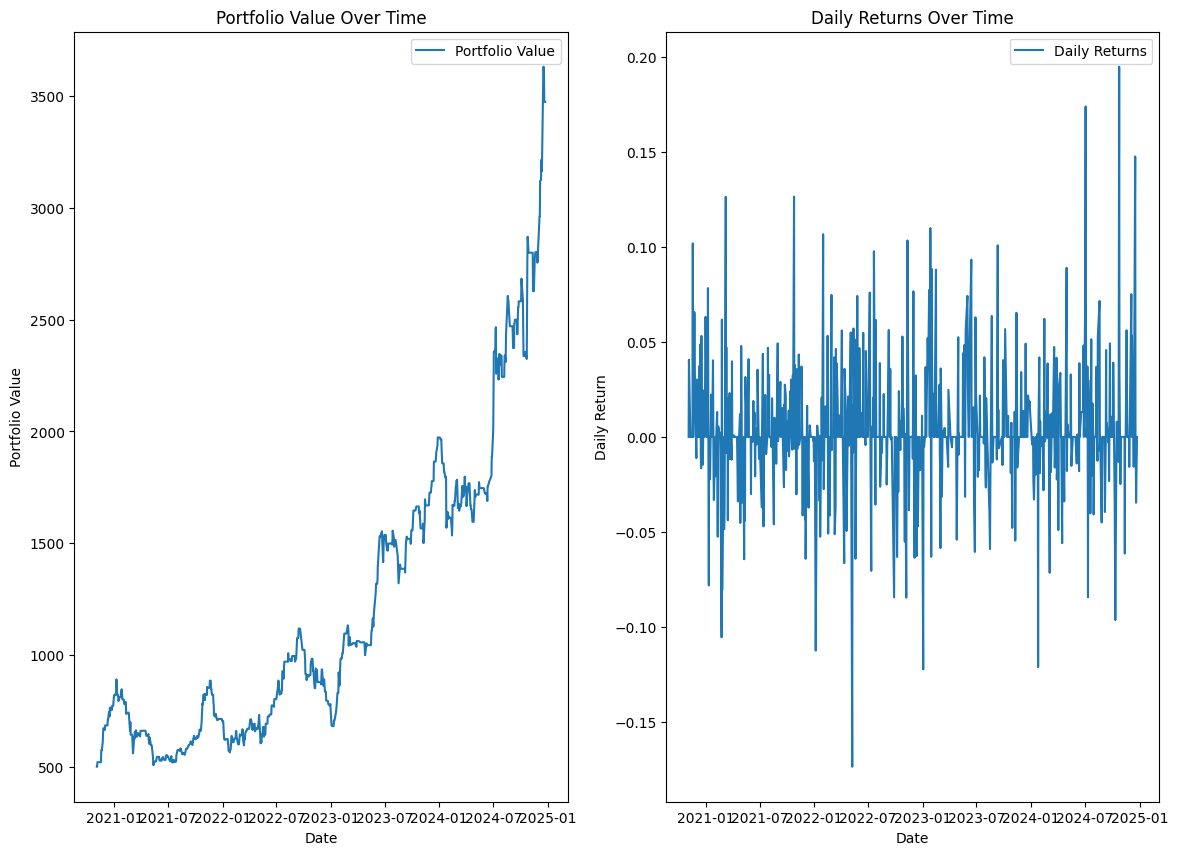

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 10))

# Portfolio Value over Time
plt.subplot(1, 2, 1)
plt.plot(date, portfolio_value, label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.legend()

# Daily Returns
plt.subplot(1, 2, 2)
plt.plot(date[1:], daily_returns, label='Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Daily Returns Over Time')
plt.legend()
plt.show()

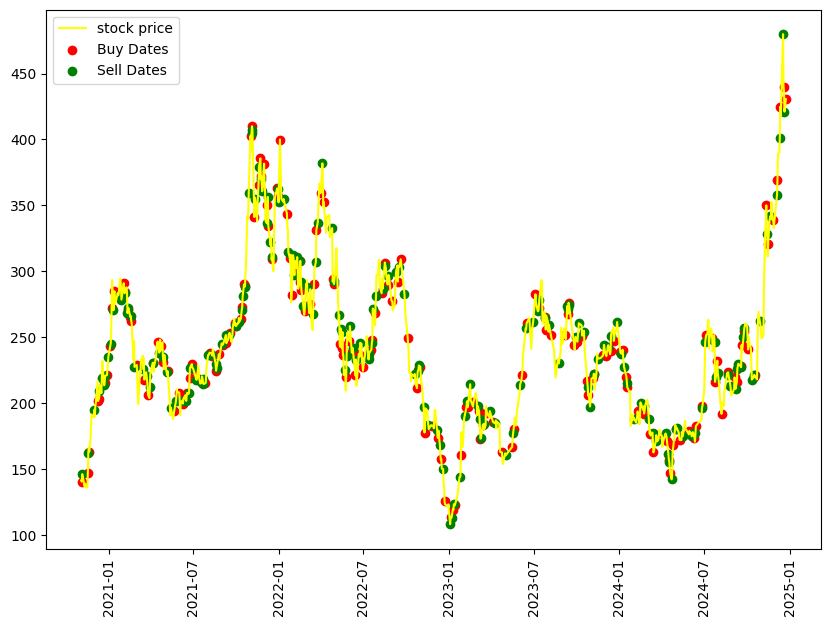

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(date,stock_final_prices,color="yellow",label="stock price")
plt.scatter(buy_time,buy_rate,color='r',label='Buy Dates')
plt.scatter(sell_time,sell_rate,color='g',label='Sell Dates')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()